In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy.special
import mpmath
import pysimul
import time
from math import *
π = np.pi

In [3]:
simul = pysimul.PySimul()
simul['T'] = 10
simul['gamma'] = 500
part_m = 0
#simul['part_m'] = part_m = 0.1
α = 0
simul['reset_rate'] = α = 1.5
simul['x0sigma'] = σ = 0

In [4]:
path = "reset-fix/langevin-reset-fix-m0"

In [5]:
simul.start()

In [ ]:
simul.end()

In [19]:
simul['n_trajectories']

9540

In [24]:
simul['pause'] = 1

In [20]:
D = simul['T']/simul['gamma']

def survdist_th_σ0 (x, t):
    return scipy.special.erf(x/(2*np.sqrt(D*t))) * np.heaviside(x,0.5)

def survdist_th_reset_σ0 (x, t):
    x = np.atleast_1d(x)
    t = np.atleast_1d(t)
    P = np.zeros((len(x),len(t)))
    for i in range(len(x)):
        def psr_lp (s):
            kappa = mpmath.sqrt( (α + s) / D )
            e = mpmath.exp(-kappa * x[i])
            return (1 - e) / (s + α*e)
        for j in range(len(t)):
            if x[i] < 0:
                P[i,j] = 0
            else:
                P[i,j] = mpmath.invertlaplace(psr_lp, t[j], method='talbot')
    return np.squeeze(P)

Px0_f = lambda x: np.exp(-(x/σ)**2/2)/(sqrt(2*π)*σ)

In [21]:
# func1 should decrease away from 0 : only 2*N1+1 points are sampled,
# alors que func2 est évaluée autant qu'il faut
# Nout << N1
def convolve_around_0 (func1, func2, N1, Nout, Δx):
    # samples of func1
    X1 = np.linspace(-N1*Δx, +N1*Δx, 2*N1+1)
    Y1 = func1( X1 )
    # output
    Conv_x = np.linspace(-Nout*Δx, +Nout*Δx, 2*Nout+1)
    Conv = np.zeros(2*Nout+1)
    for i in range(2*Nout+1):
        # Conv_x[i] == Δx * (i - Nout)
        Y2 = func2( Conv_x[i] - X1 )        # à optimiser, pas besoin de ré-évaluer func2 autant…
        Conv[i] = np.sum( Y1 * Y2 ) * Δx
    return Conv_x, Conv

def convolve_around_0 (func1, func2, N1, Nout, Δx):
    # samples of func1
    X1 = np.linspace(-N1*Δx, +N1*Δx, 2*N1+1)
    Y1 = func1( X1 )
    # samples of func2
    X2 = np.linspace((-N1-Nout)*Δx, (+N1+Nout)*Δx, 2*(N1+Nout)+1)
    Y2 = func2( X2 )
    # output
    Conv_x = np.linspace(-Nout*Δx, +Nout*Δx, 2*Nout+1)
    Conv = np.zeros(2*Nout+1)
    for i in range(2*Nout+1):
        Y2loc = Y2[i:i+2*N1+1]
        Conv[i] = np.sum( Y1 * Y2loc ) * Δx
    return Conv_x, Conv

def convolve_parametric_singlept (func1, func2, N1, Δx, x_eval, Param2):
    # samples of func1
    X1 = np.linspace(-N1*Δx, +N1*Δx, 2*N1+1)
    Y1 = func1( X1 )
    # output
    Z = np.zeros(len(Param2))
    for k in range(len(Param2)):
        Y2 = func2( x_eval - X1, Param2[k] )
        Z[k] = np.sum( Y1 * Y2 ) * Δx
    return Z

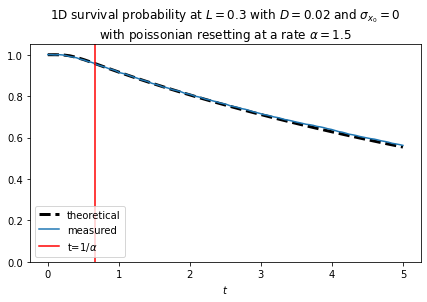

In [27]:
(acc, samples) = simul["survdist_time"]
survdist_time = acc/samples*len(acc)
x_targ = simul['survdist_time_pos']

t = t_th = np.linspace(0, simul["survdist_max_t"], len(acc))+1e-100
if σ < 0.001:
    if α < 1e-10:
        Pt_th = survdist_th_σ0( x_targ, t_th )
    else:
        t_th = np.linspace(0, simul["survdist_max_t"], 50)+1e-10
        Pt_th = survdist_th_reset_σ0( x_targ, t_th )
else:
    if α < 1e-10:
        Pt_th = convolve_parametric_singlept(Px0_f, survdist_th_σ0, 5000, 0.001, x_targ, t_th)
    else:
        #t_th = np.linspace(0, simul["survdist_max_t"], 30)+1e-10
        #Pt_th = convolve_parametric_singlept(Px0_f, survdist_th_reset_σ0, 50, 0.1, x_targ, t_th)
        #
        # ne fonctionne pas, la courbe théorique est probablement plus compliquée !
        t_th = [0]
        Pt_th = [float('nan')]

plt.figure(figsize=(7,4))

#plt.plot(t_th, Pt_th, label=r"theoretical ($m=0$)", color='black', linestyle='dashed', lw=3)
plt.plot(t_th, Pt_th, label=r"theoretical", color='black', linestyle='dashed', lw=3)
#plt.plot(t_th, Pt_th, label=r"théorique ($m=0$)", color='black', linestyle='dashed', lw=3)

#plt.plot(t, survdist_time, label=r"measured ($m/\gamma={:.1e}$)".format(simul['part_m']/simul['gamma']))
plt.plot(t, survdist_time, label=r"measured")
#plt.plot(t, survdist_time, label=r"mesuré ($m/\gamma=2\cdot 10^{-4}$)")

plt.xlabel("$t$")
plt.ylim((0,1.05))
title = r"1D survival probability at $L={}$ with $D={}$ and $\sigma_{{x_0}}={}$".format(x_targ,D,σ)
#title = r"Probabilité de survie 1D à $L={}$ avec $D={}$".format(x_targ,D)
if α > 1e-10:
    title += "\n"+r"with poissonian resetting at a rate $\alpha={}$".format(α)
    #title += "\n"+r"et réinitialisation poissonienne de taux $\alpha={}$".format(α)
    plt.axvline(x=1/α, label=r"t=$1/\alpha$", color='red')
plt.title(title)
plt.legend(loc='lower left')
plt.savefig(path+"-survival-time.pdf", bbox_inches='tight')

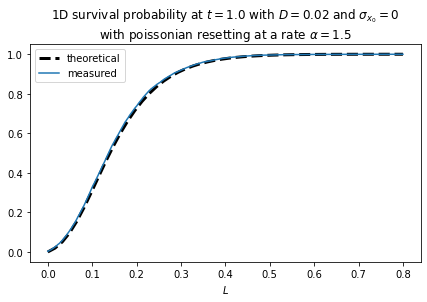

In [28]:
(acc, samples) = simul['survdist_pos']
survdist_pos = acc/samples

t_sample = simul['survdist_pos_time']
xtarg = np.linspace(0, simul['survdist_max_x'], len(acc))
if σ < 0.001:
    if α < 1e-10:
        xtarg_th = xtarg
        Pxtarg_th = survdist_th_σ0(xtarg, t_sample)
    else:
        xtarg_th = np.linspace(0, simul['survdist_max_x'], 50)
        Pxtarg_th = survdist_th_reset_σ0(xtarg_th, t_sample)
else:
    if α < 1e-10:
        Δx = simul['survdist_max_x'] / len(acc)
        surv_f = lambda x: survdist_th_σ0(x, t_sample)
        x,P = convolve_around_0(Px0_f, surv_f, 5000, len(acc)-1, Δx)
        xtarg_th = xtarg = x[len(acc)-1:]
        Pxtarg_th = P[len(acc)-1:]
    else:
        #xtarg_th = np.linspace(0, simul['survdist_max_x'], 50)
        #surv_f = lambda x: survdist_th_reset_σ0(x, t_sample)
        #Δx = 0.01
        #N = int(simul['survdist_max_x']/Δx)
        #x,P = convolve_around_0(Px0_f, surv_f, 100, N, Δx)
        #xtarg_th = x[N:]
        #Pxtarg_th = P[N:]
        #
        # ne fonctionne pas, la courbe théorique est probablement plus compliquée !
        xtarg_th = [0]
        Pxtarg_th = [float('nan')]

plt.figure(figsize=(7,4))

#plt.plot(xtarg_th, Pxtarg_th, label=r"theoretical ($m=0$)", color='black', linestyle='dashed', lw=3)
plt.plot(xtarg_th, Pxtarg_th, label=r"theoretical", color='black', linestyle='dashed', lw=3)
#plt.plot(xtarg, survdist_pos, label=r"measured ($m/\gamma={:.1e}$)".format(simul['part_m']/simul['gamma']))
#plt.plot(xtarg, survdist_pos, label=r"mesuré ($m/\gamma=2\cdot 10^{-4}$)")
plt.plot(xtarg, survdist_pos, label=r"measured")

plt.ylim((-0.05, 1.05))
#plt.xlabel(r"$x_\operatorname{target}$")
plt.xlabel(r"$L$")
title = r"1D survival probability at $t={}$ with $D={}$ and $\sigma_{{x_0}}={}$".format(t_sample,D,σ)
#title = r"Probabilité de survie 1D à $t={}$ avec $D={}$".format(t_sample,D)
if α > 1e-10:
    title += "\n"+r"with poissonian resetting at a rate $\alpha={}$".format(α)
#    title += "\n"+r"et réinitialisation poissonienne de taux $\alpha={}$".format(α)
plt.title(title)
plt.legend()
plt.savefig(path+"-survival-xtarg.pdf", bbox_inches='tight')

Difference between survival distribution for time and position at the common sampled point :

In [24]:
ix = np.searchsorted(xtarg, x_targ)
it = np.searchsorted(t, t_sample)
print("{:.2f} %".format(100*abs(survdist_pos[ix]-survdist_time[it])/survdist_pos[ix]))

0.77 %


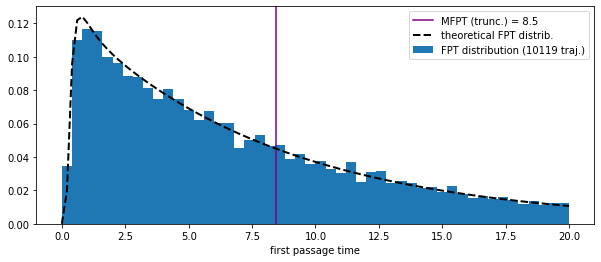

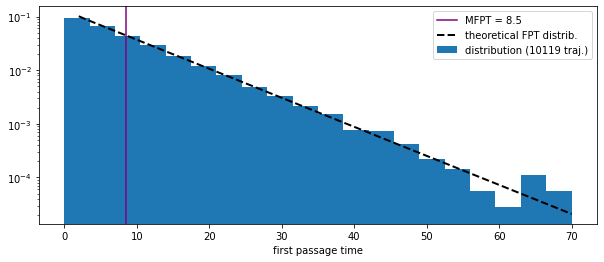

In [25]:
def pft_free (t, x_targ):
    return x_targ/(2*np.sqrt(π*D*t**3)) * np.exp(-x_targ**2/(4*D*t))

def pft_reset (t, x_targ):
    def pftr_lp (s):
        kappa = mpmath.sqrt( (α + s) / D )
        e = mpmath.exp(-kappa*x_targ)
        return -s * (1 - e) / (s + α*e)
    Pft = np.zeros(len(t))
    for k in range(len(t)):
        Pft[k] = mpmath.invertlaplace(pftr_lp, t[k], method='talbot')
    return Pft

first_times = simul['first_times-0']
mfpt = np.mean(first_times)
n_traj = len(first_times)
np.savetxt(path+"-ft.csv", first_times, fmt='%.3e')

plt.figure(figsize=(10,4))
plt.hist(first_times, bins=50, range=(0,20), weights=50/20*np.ones(n_traj)/n_traj, label="FPT distribution ({} traj.)".format(n_traj))
if mfpt < 20:
    plt.axvline(x=mfpt, color='purple', label="MFPT (trunc.) = {:.2}".format(mfpt))
if σ < 0.001:
    if α < 1e-10:
        t = np.linspace(0,20,200)+1e-10
        Pft = pft_free(t, x_targ)
    else:
        t = np.linspace(0,20,100)+1e-10
        Pft = pft_reset(t, x_targ)
    plt.plot(t, Pft, label=r"theoretical FPT distrib.", color='black', linestyle='dashed', lw=2)
plt.xlabel("first passage time")
plt.legend()
plt.savefig(path+"-detail-fpt.pdf", bbox_inches='tight')

plt.figure(figsize=(10,4))
plt.hist(first_times, bins=20, range=(0,70), weights=20/70*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT = {:.2}".format(mfpt))
if σ < 0.001:
    t = np.linspace(2,70,100)
    if α < 1e-10:
        Pft = pft_free(t, x_targ)
    else:
        Pft = pft_reset(t, x_targ)
    plt.plot(t, Pft, label=r"theoretical FPT distrib.", color='black', linestyle='dashed', lw=2)
    #plt.plot(t, Pft, label=r"distribution théorique du FPT", color='black', linestyle='dashed', lw=2)
plt.yscale('log')
plt.xlabel("first passage time")
#plt.xlabel("temps de premier passage (FPT)")
plt.legend()
plt.savefig(path+"-broad-fpt.pdf", bbox_inches='tight')

In [26]:
pd.DataFrame(list({
    'D': D,
    'T': simul['T'],
    'gamma': simul['gamma'],
    'part_m': part_m,
    'reset_rate': α,
    'x0sigma': σ,
    'L': x_targ,
    'b': x_targ/np.float64(σ),
    'c': sqrt(α/D)*x_targ,
}.items())).set_index(0).to_csv(path+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
